In [1]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import os
import pandas as pd
import numpy as np
import rpy2.robjects as ro
import sys

import scanpy as sc
import matplotlib.pyplot as plt

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

c:\Users\kyria.000\anaconda3\envs\Py310\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
%%R
options(future.globals.maxSize = 1000000 * 1024^2)
set.seed(2422012)

# Single cell libraries
library(Seurat)
library(sctransform)
library(rliger)
library(SeuratWrappers)
library(conos)
library(scater)
library(scDblFinder)
library(scran)
library(sctransform)
library(scry)

# Rest libraries
library(BiocParallel)
library(ggplot2)
library(dplyr)
library(cowplot)

library(scCustomize)
library(stringr)
library(dittoSeq)
library(DESeq2)
library(enrichR)

library(tidyverse)
library(org.Hs.eg.db)
library(clusterProfiler)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    -- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.2.0     v purrr   1.0.1
v tidyr   1.3.0     v forcats 1.0.0
v readr   2.1.3     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tibble::as_data_frame() masks dplyr::as_data_frame(), igraph::as_data_frame()
x dplyr::collapse()       masks IRanges::collapse()
x dplyr::combine()        masks Biobase::combine(), BiocGenerics::combine()
x purrr::compose()        masks igraph::compose()
x dplyr::count()          masks matrixStats::count()
x tidyr::crossing()       masks igraph::crossing()
x dplyr::desc()           masks IRanges::desc()
x tidyr::expand()         masks S4Vectors::expand(), Matrix::expand()
x dplyr::filter()         masks stats::filter()
x dplyr::first()       

In [3]:
CellType="CCR7pCD45ROp"
title_plot = "CD45RO+CCR7+"

In [4]:
projectdir = "C:/Users/kyria.000/Documents/PhD/Projects/Feng2023/CoPImmunoPD/"
datadir = projectdir + "Data/"
objtdir = projectdir + "Result/Differnetial_Expression_pct_03/"

resultdir = projectdir + "Result/Differnetial_Expression_pct_03/"+CellType+"/"
adata_file = 'AnnData_Integrated.h5ad'


In [5]:
%%R -i projectdir
setwd(projectdir)

In [6]:
%%R -i objtdir -i resultdir -i projectdir
# setwd(projectdir)
dir.create(objtdir)
dir.create(resultdir)
Subbbb <- readRDS(paste0(projectdir,"Subset_raarranged.rds"))

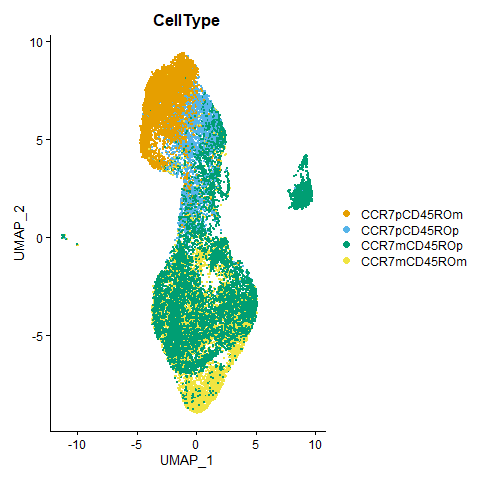

In [7]:
%%R -i resultdir -i projectdir
DimPlot(Subbbb,group.by="CellType",cols=c(dittoColors(1)[seq_len(4)]))

In [8]:
%%R
DefaultAssay(Subbbb) <- "SCT"
# ====== Find markers parameters  ==============
min_pct_threshold = 0.3
# ====== Go enrichment parameters ==============
logfc.threshold <- 0.25
p.val.cutoff <- 0.05
max.genes <- 500


# Subset different CD8 T cells

In [9]:
%%R -i CellType
# ====================== CCR7mCD45ROp ================================
Seurat = subset(Subbbb, idents = CellType)
Seurat<- SetIdent(Seurat , value = "Condition")
Seurat <- PrepSCTFindMarkers(Seurat)

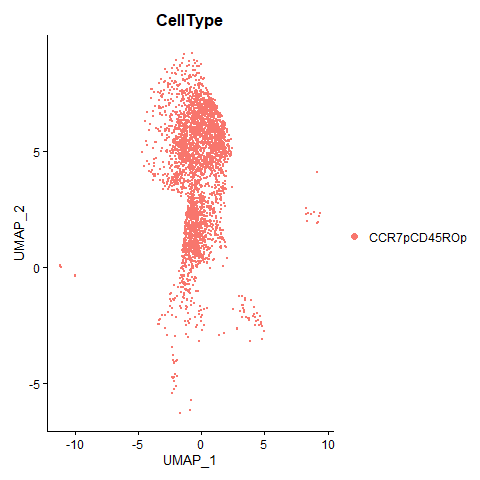

In [10]:
%%R
DimPlot(Seurat,group.by="CellType")

# Create Average Expression

In [11]:
%%R
source(paste0(projectdir,"Functions.R"))

In [12]:
%%R -i resultdir -i CellType
Idents(Seurat) <- "Condition"
Average_Seurat <- AverageExpression(Seurat,return.seurat=T)
Average_Seurat_norm <- as.data.frame(Average_Seurat@assays$SCT@data)
rownames(Average_Seurat_norm) <- rownames(Average_Seurat)
colnames(Average_Seurat_norm)<- paste0(rownames(Average_Seurat@meta.data),"_norm")
Average_Seurat_counts <- as.data.frame(Average_Seurat@assays$RNA@data)
rownames(Average_Seurat_counts) <- rownames(Average_Seurat)
colnames(Average_Seurat_counts)<- paste0(rownames(Average_Seurat@meta.data),"_counts")
Average_Seurat <- as.data.frame(cbind(Average_Seurat_counts,Average_Seurat_norm))
write.csv(Average_Seurat,paste0(resultdir,"Average_",CellType,".csv"))


# Differential Expression

In [13]:
%%R
DE_Seurat_original <-  FindMarkers(Seurat,ident.1="PD",ident.2="HC",
    min.pct = min_pct_threshold,
    logfc.threshold = 0
    )

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~51s           |++                                                | 2 % ~48s           |++                                                | 3 % ~49s           |+++                                               | 4 % ~48s           |+++                                               | 5 % ~46s           |++++                                              | 6 % ~45s           |++++                                              | 7 % ~43s           |+++++                                             | 8 % ~42s           |+++++                                             | 9 % ~41s           |++++++                                            | 10% ~40s           |++++++                                            | 11% ~39s           |+++++++                                           | 12% ~38s           |+++++++                                           | 13% ~37s 

In [14]:
%%R
source("Functions.R")
DE_Seurat <- DE_Seurat_original
DE_Seurat$gene <-  rownames(DE_Seurat)
DE_Seurat  <- gene_score_calc(DE_Seurat)


# ADD ENSEMBL IDs

In [15]:
%%R -i projectdir
gene_names <- as.data.frame(readr::read_tsv(paste0(projectdir,"features.tsv"),col_names =F))
colnames(gene_names) <- c("ensembl.id","gene.name","Type")
DE_Seurat$gene.name <- DE_Seurat$gene


remain_ensembl.id <- gene_names[gene_names$gene.name %in% DE_Seurat$gene.name,]
doublicated_gene <- duplicated(remain_ensembl.id$gene.name)
remain_ensembl.id2 <- remain_ensembl.id[!doublicated_gene,]
rownames(remain_ensembl.id2) <- remain_ensembl.id2$gene.name
DE_Seurat$ensembl.id <- remain_ensembl.id2[DE_Seurat$gene.name,"ensembl.id"]
print(DE_Seurat[1:5,])


Rows: 36601 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): X1, X2, X3

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
             gene     tstat gene.score p_val p_val_adj diff.pct
HIST1H1E HIST1H1E 117.21804    3.15312     0         0    0.349
CFAP70     CFAP70 107.57241    4.17935     0         0    0.287
TXNIP       TXNIP 107.30767    0.93547     0         0    0.048
RNF125     RNF125 -97.39269   -1.30520     0         0   -0.212
ZFP36L2   ZFP36L2 -87.65396   -0.75138     0         0   -0.025
         enrichment.ratio pct.1 pct.2 avg_log2FC cluster gene.name
HIST1H1E          4.17269 0.459 0.110    0.75566      PD  HIST1H1E
CFAP70            6.73987 0.337 0.050    0.62009      PD    CFAP70
TXNIP             1.05189 0.973 0.925    0.88932      PD     TXNIP
RNF125            1.30503 0.695 0.907   -1.00013     

# ADD ENTREZ IDs

In [16]:
%%R
source("Functions.R")
rownames(DE_Seurat) <- DE_Seurat$gene.name
geneIDs <- DE_Seurat[,c("gene.name","ensembl.id")]
DE_Seurat_mapped <- entrezMapper(DEGenes=DE_Seurat, geneIDs=geneIDs, species="hsa")



FALSE  TRUE 
 2780    25 


In [17]:
%%R
cleanDEGenes <- DE_Seurat_mapped[!is.na(DE_Seurat_mapped$entrezID),]
print(dim(cleanDEGenes))
print(dim(DE_Seurat_mapped))

[1] 2780   14
[1] 2805   14


In [18]:
%%R
DE_Seurat_signif <- cleanDEGenes %>%
  filter(abs(avg_log2FC)>0.25 &  p_val_adj <0.05) %>%
  arrange(desc(gene.score))
DE_Seurat_signif[1:5,]

             gene     tstat gene.score p_val p_val_adj diff.pct
CFAP70     CFAP70 107.57241    4.17935     0         0    0.287
HIST1H1E HIST1H1E 117.21804    3.15312     0         0    0.349
HIST1H1D HIST1H1D  79.62442    2.12086     0         0    0.286
HIST1H1C HIST1H1C  85.78760    2.09947     0         0    0.311
FAAH2       FAAH2  33.43738    1.18203     0         0    0.207
         enrichment.ratio pct.1 pct.2 avg_log2FC cluster gene.name
CFAP70            6.73987 0.337 0.050    0.62009      PD    CFAP70
HIST1H1E          4.17269 0.459 0.110    0.75566      PD  HIST1H1E
HIST1H1D          3.46549 0.402 0.116    0.61200      PD  HIST1H1D
HIST1H1C          3.01946 0.465 0.154    0.69531      PD  HIST1H1C
FAAH2             1.83805 0.454 0.247    0.64309      PD     FAAH2
              ensembl.id entrezID
CFAP70   ENSG00000156042   118491
HIST1H1E ENSG00000168298     3008
HIST1H1D ENSG00000124575     3007
HIST1H1C ENSG00000187837     3006
FAAH2    ENSG00000165591   158584


In [19]:
%%R -i CellType
Average_subset_ordered <- Average_Seurat[DE_Seurat$gene,]
DE_Seurat <- as.data.frame(cbind(DE_Seurat,Average_subset_ordered))
DE_Seurat <- DE_Seurat[order(DE_Seurat$gene.score,decreasing=T),]
readr::write_csv(DE_Seurat,
    file=paste0(resultdir,CellType,"DEG_MinPct_",min_pct_threshold,".csv"))


Saving 6.67 x 6.67 in image


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


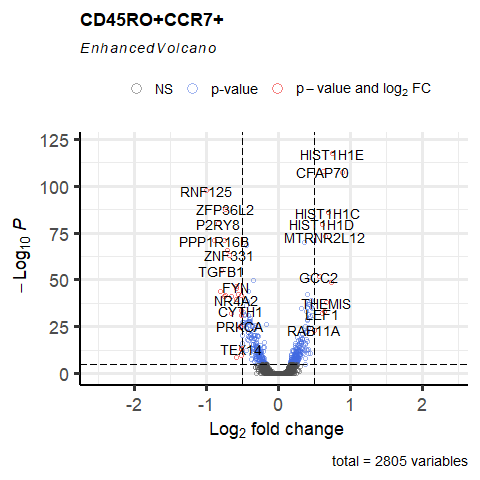

In [21]:
%%R -i resultdir -i title_plot
library(EnhancedVolcano)
p <- EnhancedVolcano(DE_Seurat_original,
    lab = rownames(DE_Seurat_original),
    x = 'avg_log2FC',
    y = 'p_val',
    FCcutoff = 0.5,
    title=title_plot,
    pointSize = 3.0,
    labSize = 6.0,
    colAlpha = 1,
    shape = 1)
ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_pvalue.png"))
ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_pvalue.pdf"))
p

p <- EnhancedVolcano(DE_Seurat_original,
    lab = rownames(DE_Seurat_original),
    x = 'avg_log2FC',
    y = 'p_val_adj',
    FCcutoff = 0.5,
    title=title_plot,
    shape =1)
ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_adjustedp.png"))
ggsave(plot=p,filename=paste0(resultdir,CellType,"_Volcano_pct",min_pct_threshold,"_adjustedp.pdf"))
p

# Kegg Pathway

## Possitive PD

In [22]:
%%R
source("Functions.R")
enrich.database <- c("KEGG_2021_Human")
mypos <- enrichR_wrap_fun_pos(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
pos.markers <- mypos$pos.markers
# ======= Enrichment matrix ===================
pos_mat <- mypos$pos_mat
print(pos_mat[1:3,1:2])
kegg_pos_mat <- pos_mat  
readr::write_csv(pos_mat,
    file=paste0(resultdir,CellType,"_POS_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))


Uploading data to Enrichr... Done.
  Querying KEGG_2021_Human... Done.
Parsing results... Done.
                     KEGG_2021_Human.Term KEGG_2021_Human.Overlap
1 Human T-cell leukemia virus 1 infection             ratio 7/219
2     NOD-like receptor signaling pathway             ratio 6/181
3                 Cell adhesion molecules             ratio 5/148


In [23]:
%%R
print("Take a break enrichr crashes")


[1] "Take a break enrichr crashes"


## Negative PD

In [24]:
%%R
source("Functions.R")
enrich.database <- c("KEGG_2021_Human")
myneg <- enrichR_wrap_fun_neg(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
neg.markers <- myneg$neg.markers
# ======= Enrichment matrix ===================
neg_mat <- myneg$neg_mat
print(neg_mat[1:3,1:2])
kegg_neg_mat <- neg_mat  
readr::write_csv(neg_mat,
    file=paste0(resultdir,CellType,"_NEG_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))

Uploading data to Enrichr... Done.
  Querying KEGG_2021_Human... Done.
Parsing results... Done.
            KEGG_2021_Human.Term KEGG_2021_Human.Overlap
1                      Apoptosis             ratio 7/142
2   Epstein-Barr virus infection             ratio 8/202
3 Sphingolipid signaling pathway             ratio 6/119


Saving 12 x 6.67 in image
Saving 12 x 6.67 in image


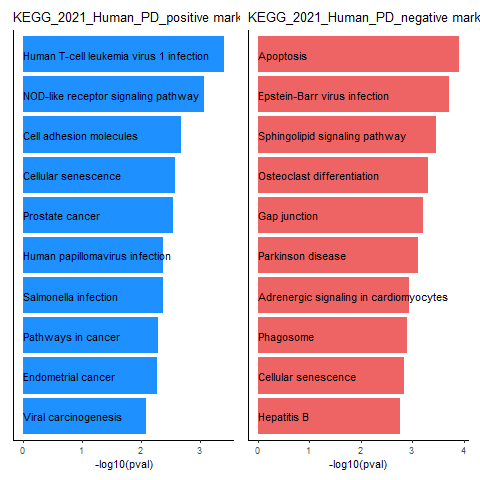

In [25]:
%%R
enrich.database <- "KEGG_2021_Human"
p <- plot_enrichR_wrap_fun(
        ident.1="PD",
        ident.2="HC",
        pos.er = kegg_pos_mat,
        neg.er = kegg_neg_mat,
        enrich.database= enrich.database )


ggsave(plot=p,filename=paste0(resultdir,"BarPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=12)
ggsave(plot=p,filename=paste0(resultdir,"BarPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=12)
p

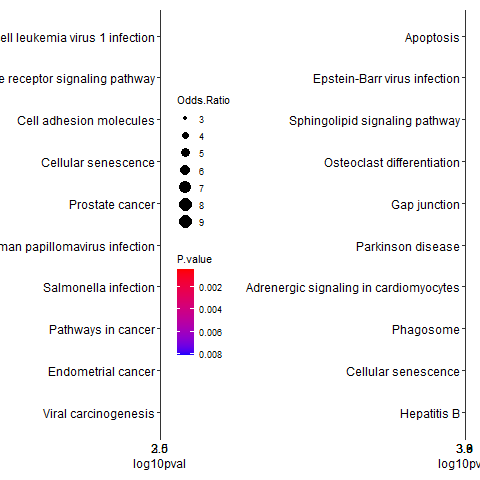

In [26]:
%%R
source("Functions.R")
enrich.database <- "KEGG_2021_Human"
p <- dotplot_enrich_dim(pos_mat=kegg_pos_mat , neg_mat=kegg_neg_mat,n_paths=10)

ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=20,height=6)
ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=20,height=6)

p



# Reactome Pathway

## Possitive PD

In [27]:
%%R
source("Functions.R")
enrich.database <- c("Reactome_2022")
mypos <- enrichR_wrap_fun_pos(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
pos.markers <- mypos$pos.markers
# ======= Enrichment matrix ===================
pos_mat <- mypos$pos_mat
print(pos_mat[1:3,1:2])




pos_IDs <- unlist(lapply( pos_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        ID <- splitted_str[grep("R-HSA",splitted_str)]
        return(ID)
    }))
pos_mat$ID <- pos_IDs
pos_Term <- unlist(lapply( pos_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        Term_text <- paste(splitted_str[1:indxex_id-1],collapse=" ")
        return(Term_text)
    }))
pos_mat$term <- pos_Term
pos_mat$term <- factor(pos_Term,levels= pos_Term)

reactome_pos_mat <- pos_mat  


readr::write_csv(pos_mat,
    file=paste0(resultdir,CellType,"_POS_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))


Uploading data to Enrichr... 

Done.
  Querying Reactome_2022... Done.
Parsing results... Done.
                                                  Reactome_2022.Term
1                       Signaling By ERBB2 ECD Mutants R-HSA-9665348
2 Signaling By ALK Fusions And Activated Point Mutants R-HSA-9725370
3                        Signaling By ERBB2 KD Mutants R-HSA-9664565
  Reactome_2022.Overlap
1            ratio 3/15
2            ratio 4/55
3            ratio 3/24


## Negative PD

In [28]:
%%R
source("Functions.R")
enrich.database<- c("Reactome_2022")
myneg <- enrichR_wrap_fun_neg(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
neg.markers <- myneg$neg.markers
# ======= Enrichment matrix ===================
neg_mat <- myneg$neg_mat
print(neg_mat[1:3,1:2])


neg_IDs <- unlist(lapply( neg_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        ID <- splitted_str[grep("R-HSA",splitted_str)]
        return(ID)
    }))
neg_mat$ID <- neg_IDs
neg_Term <- unlist(lapply( neg_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        Term_text <- paste(splitted_str[1:indxex_id-1],collapse=" ")
        return(Term_text)
    }))
neg_mat$term <- neg_Term

reactome_neg_mat <- neg_mat  

readr::write_csv(neg_mat,
    file=paste0(resultdir,CellType,"_NEG_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))

Uploading data to Enrichr... Done.
  Querying Reactome_2022... Done.
Parsing results... Done.
                                 Reactome_2022.Term Reactome_2022.Overlap
1 Cytokine Signaling In Immune System R-HSA-1280215          ratio 19/702
2                        Immune System R-HSA-168256         ratio 34/1943
3                           Hemostasis R-HSA-109582          ratio 16/576


Saving 12 x 6.67 in image
Saving 12 x 6.67 in image


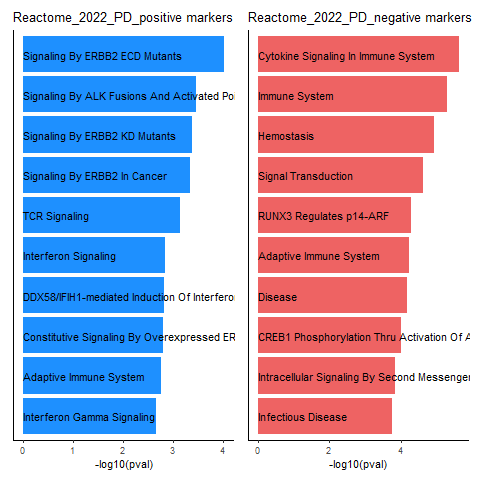

In [29]:
%%R
enrich.database <- "Reactome_2022"
p <- plot_enrichR_wrap_fun(
        ident.1="PD",
        ident.2="HC",
        pos.er = reactome_pos_mat,
        neg.er = reactome_neg_mat,
        enrich.database= enrich.database )

ggsave(plot=p,filename=paste0(resultdir,"BarPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=12)
ggsave(plot=p,filename=paste0(resultdir,"BarPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=12)
p

In [30]:
%%R
colnames(reactome_neg_mat)

 [1] "Reactome_2022.Term"                 "Reactome_2022.Overlap"             
 [3] "Reactome_2022.P.value"              "Reactome_2022.Adjusted.P.value"    
 [5] "Reactome_2022.Old.P.value"          "Reactome_2022.Old.Adjusted.P.value"
 [7] "Reactome_2022.Odds.Ratio"           "Reactome_2022.Combined.Score"      
 [9] "Reactome_2022.Genes"                "log10pval"                         
[11] "term"                               "ID"                                


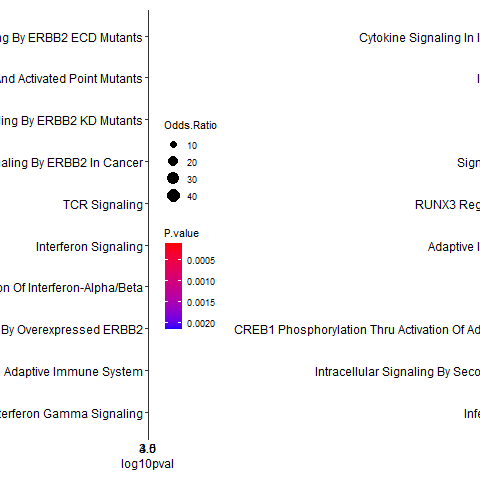

In [31]:
%%R
source("Functions.R")
enrich.database <- "Reactome_2022"
p <- dotplot_enrich_dim(pos_mat=reactome_pos_mat , neg_mat=reactome_neg_mat,n_paths=10)

ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=20,height=6)
ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=20,height=6)
p



# GO Pathway

## Possitive PD

In [32]:
%%R
source("Functions.R")
enrich.database <- c("GO_Biological_Process_2021")
mypos <- enrichR_wrap_fun_pos(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
pos.markers <- mypos$pos.markers
# ======= Enrichment matrix ===================
pos_mat <- mypos$pos_mat
print(pos_mat[1:3,1:2])
go_pos_mat <- pos_mat  
readr::write_csv(pos_mat,
    file=paste0(resultdir,CellType,"_POS_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))


Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
                                  GO_Biological_Process_2021.Term
1                                  B cell activation (GO:0042113)
2                         mRNA splice site selection (GO:0006376)
3 negative regulation of nucleocytoplasmic transport (GO:0046823)
  GO_Biological_Process_2021.Overlap
1                         ratio 6/85
2                         ratio 4/30
3                         ratio 3/13


## Negative PD

In [33]:
%%R
source("Functions.R")
enrich.database<- c("GO_Biological_Process_2021")
myneg <- enrichR_wrap_fun_neg(DE_Seurat_mapped,
logfc.threshold=logfc.threshold,
p.val.cutoff=p.val.cutoff,
enrich.database=c(enrich.database ))    
# ======= DEGs matrix ===================
neg.markers <- myneg$neg.markers
# ======= Enrichment matrix ===================
neg_mat <- myneg$neg_mat
print(neg_mat[1:3,1:2])
go_neg_mat <- neg_mat  
readr::write_csv(neg_mat,
    file=paste0(resultdir,CellType,"_NEG_",enrich.database,"_MinPct_",min_pct_threshold,".csv"))

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.
                                 GO_Biological_Process_2021.Term
1               cytokine-mediated signaling pathway (GO:0019221)
2            regulation of fat cell differentiation (GO:0045598)
3 positive regulation of macrophage differentiation (GO:0045651)
  GO_Biological_Process_2021.Overlap
1                       ratio 16/621
2                         ratio 6/80
3                         ratio 3/11


Saving 12 x 6.67 in image
Saving 12 x 6.67 in image


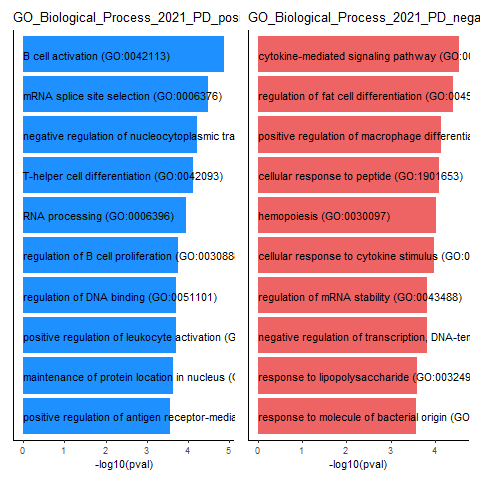

In [34]:
%%R
enrich.database <- "GO_Biological_Process_2021"
p <- plot_enrichR_wrap_fun(
        ident.1="PD",
        ident.2="HC",
        pos.er = go_pos_mat,
        neg.er = go_neg_mat,
        enrich.database= enrich.database )

ggsave(plot=p,filename=paste0(resultdir,
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=12)
ggsave(plot=p,filename=paste0(resultdir,
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=12)
p

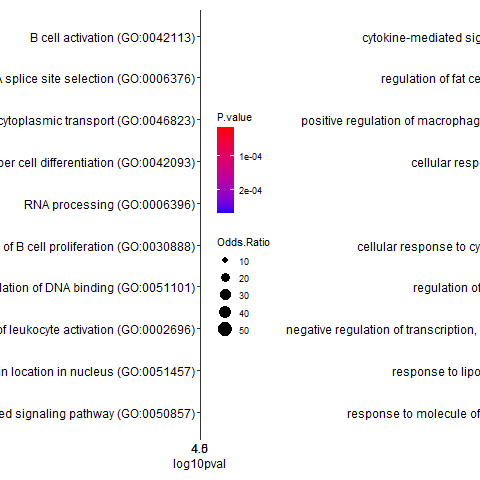

In [35]:
%%R
source("Functions.R")
enrich.database <- "GO_Biological_Process_2021"
p <- dotplot_enrich_dim(pos_mat=go_pos_mat , neg_mat=go_neg_mat,n_paths=10)

ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".png"),width=20,height=6)
ggsave(plot=p,filename=paste0(resultdir,"DotPlot_",
        CellType,"_",enrich.database,"_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_p.val.cutoff_"=p.val.cutoff,
        ".pdf"),width=20,height=6)
p

# Calculate RANKS based on FC

In [36]:
%%R
ranks_avg_log2FC<- tibble::deframe( DE_Seurat_mapped%>%  dplyr::select(entrezID , avg_log2FC   )) 
ranks_avg_log2FC[1:4]
gsea_kegg_log2FC <- gseKEGG(sort(ranks_avg_log2FC,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
readr::write_csv(as.data.frame(gsea_kegg_log2FC),
        file=paste0(resultdir,CellType,"_KEGG_GSEA_MinPct_",min_pct_threshold,"_Ranks_log2FC.csv"))

#  TOP UP GSEA KEGG

In [37]:
%%R
library(enrichplot)
sort_filt_gsea_kegg_log2FC <- gsea_kegg_log2FC[match(tolower(kegg_pos_mat$term[1:10]),tolower(gsea_kegg_log2FC$Description)),]

temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_KeggGSEAPlot/")
dir.create(temp_dir)
top_pos <- sort_filt_gsea_kegg_log2FC
for (row_iter in 1:10){
    id_term <- top_pos$ID[row_iter]
    text_term <- top_pos$Description[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_kegg_log2FC, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.threshold_",logfc.threshold,
            "_Ranks_log2FC_up.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Human T-cell leukemia virus 1 infection"


[1] "NOD-like receptor signaling pathway"
[1] "Cell adhesion molecules"
[1] "Cellular senescence"
[1] "Prostate cancer"
[1] "Human papillomavirus infection"
[1] "Salmonella infection"
[1] "Pathways in cancer"
[1] "Endometrial cancer"
[1] "Viral carcinogenesis"


# TOP Down GSEA KEGG

In [38]:
%%R
sort_filt_gsea_kegg_log2FC <- gsea_kegg_log2FC[match(tolower(kegg_neg_mat$term[1:10]),tolower(gsea_kegg_log2FC$Description)),]
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_KeggGSEAPlot/")
dir.create(temp_dir)
top_neg <- sort_filt_gsea_kegg_log2FC
for (row_iter in 1:10){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$Description[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_kegg_log2FC, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.threshold_",logfc.threshold,
            "_Ranks_log2FC_down.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Apoptosis"


[1] "Epstein-Barr virus infection"
[1] "Sphingolipid signaling pathway"
[1] "Osteoclast differentiation"
[1] "Gap junction"
[1] "Parkinson disease"
[1] "Adrenergic signaling in cardiomyocytes"
[1] "Phagosome"
[1] "Cellular senescence"
[1] "Hepatitis B"


In [39]:
%%R
library(ReactomePA)
require(clusterProfiler)
gsea_reactome_log2FC <- gsePathway(sort(ranks_avg_log2FC,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
readr::write_csv(as.data.frame(gsea_reactome_log2FC),
        file=paste0(resultdir,CellType,"_GSEA_MinPct_",min_pct_threshold,"_Ranks_log2FC.csv"))
gsea_reactome_log2FC[1:3,"Description"]

[1] "Transmission across Chemical Synapses"                          
[2] "Neurotransmitter receptors and postsynaptic signal transmission"
[3] "Activation of AMPK downstream of NMDARs"                        


# TOP UP GSEA REACTOME

In [40]:
%%R -i resultdir -i CellType
temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_GSEAPlot/")
dir.create(temp_dir)
top_pos <- reactome_pos_mat[1:10,]
for (row_iter in 1:10){
    id_term <- top_pos$ID[row_iter]
    text_term <- as.vector(top_pos$term)[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_reactome_log2FC, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    # Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.threshold_",logfc.threshold,
            "_Ranks_log2FC_up.pdf"), height = 8.5, width = 11)
    # Create a graphical object g here
    print(p)# print it
    # Stop writing to the PDF file
    dev.off()
}


[1] "Signaling By ERBB2 ECD Mutants"


[1] "Signaling By ALK Fusions And Activated Point Mutants"
[1] "Signaling By ERBB2 KD Mutants"
[1] "Signaling By ERBB2 In Cancer"
[1] "TCR Signaling"
[1] "Interferon Signaling"
[1] "DDX58/IFIH1-mediated Induction Of Interferon-Alpha/Beta"
[1] "Constitutive Signaling By Overexpressed ERBB2"
[1] "Adaptive Immune System"
[1] "Interferon Gamma Signaling"


In [41]:
%%R
gsea_reactome_log2FC

#
# Gene Set Enrichment Analysis
#
#...@organism 	 human 
#...@setType 	 Reactome 
#...@keytype 	 ENTREZID 
#...@geneList 	 Named num [1:2805] 0.889 0.756 0.739 0.695 0.664 ...
 - attr(*, "names")= chr [1:2805] "10628" "3008" NA "3006" ...
#...nPerm 	 10000 
#...pvalues adjusted by 'BH' with cutoff <1 
#...1860 enriched terms found
'data.frame':	1860 obs. of  11 variables:
 $ ID             : chr  "R-HSA-112315" "R-HSA-112314" "R-HSA-9619483" "R-HSA-109582" ...
 $ Description    : chr  "Transmission across Chemical Synapses" "Neurotransmitter receptors and postsynaptic signal transmission" "Activation of AMPK downstream of NMDARs" "Hemostasis" ...
 $ setSize        : int  40 34 10 140 7 16 17 16 15 27 ...
 $ enrichmentScore: num  -0.605 -0.619 -0.791 -0.42 0.89 ...
 $ NES            : num  -2.02 -1.99 -1.87 -1.75 1.89 ...
 $ pvalue         : num  0.000387 0.000391 0.000411 0.000182 0.000582 ...
 $ p.adjust       : num  0.191 0.191 0.191 0.191 0.217 ...
 $ qvalue         : num  0.184 0.

## TOP Down GSEA REACTOME

In [42]:
%%R -i resultdir -i CellType
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_GSEAPlot/")
dir.create(temp_dir)
top_neg <- reactome_neg_mat[1:10,]
for (row_iter in 1:10){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$term[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_reactome_log2FC, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_log2FC_down.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Cytokine Signaling In Immune System"
[1] "Immune System"
[1] "Hemostasis"
[1] "Signal Transduction"
[1] "RUNX3 Regulates p14-ARF"
[1] "Adaptive Immune System"
[1] "Disease"
[1] "CREB1 Phosphorylation Thru Activation Of Adenylate Cyclase"
[1] "Intracellular Signaling By Second Messengers"
[1] "Infectious Disease"


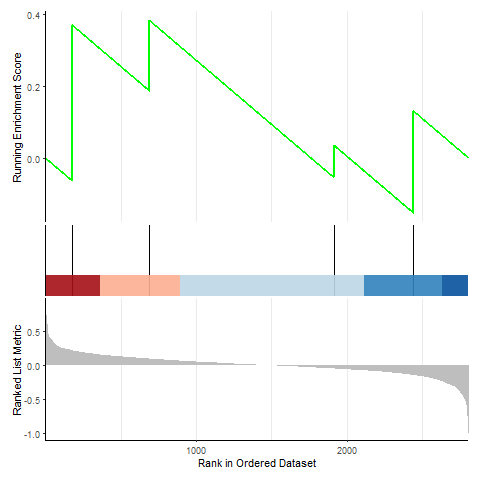

In [43]:
%%R -i resultdir -i CellType
p <- gseaplot2(gsea_reactome_log2FC, geneSetID = "R-HSA-8939246",subplots = 1:6,pvalue_table = F)
## Initiate writing to PDF file
pdf(paste0(resultdir,CellType,
       "_GSE_RUNX1_pct_",min_pct_threshold,
        "_logfc.threshold_",logfc.threshold,
        "_Ranks_log2FC.pdf"), height = 8.5, width = 11)
## Create a graphical object g here
print(p)# print it
## Stop writing to the PDF file
dev.off()
p

# Calculate RANKS based on Gene score

In [44]:
%%R
# Calculate RANKS based on genescore
ranks_avg_genescore<- tibble::deframe( DE_Seurat_mapped%>%  dplyr::select(entrezID , gene.score )) 
ranks_avg_genescore[1:4]
gsea_kegg_genescore <- gseKEGG(sort(ranks_avg_genescore,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
readr::write_csv(as.data.frame(gsea_kegg_log2FC),
        file=paste0(resultdir,CellType,"_KEGG_GSEA_MinPct_",min_pct_threshold,"_Ranks_genescore.csv"))

In [45]:
%%R
kegg_pos_mat[1,]

                     KEGG_2021_Human.Term KEGG_2021_Human.Overlap
1 Human T-cell leukemia virus 1 infection             ratio 7/219
  KEGG_2021_Human.P.value KEGG_2021_Human.Adjusted.P.value
1            0.0003960564                       0.07643889
  KEGG_2021_Human.Old.P.value KEGG_2021_Human.Old.Adjusted.P.value
1                           0                                    0
  KEGG_2021_Human.Odds.Ratio KEGG_2021_Human.Combined.Score
1                   5.646514                       44.23453
                     KEGG_2021_Human.Genes log10pval
1 MAP3K1;PIK3CA;PTEN;ATM;HLA-F;ETS1;PRKACB  3.402243
                                     term
1 Human T-cell leukemia virus 1 infection


In [46]:
%%R
library(enrichplot)
sort_filt_gsea_kegg_genescore <- gsea_kegg_genescore[match(tolower(kegg_pos_mat$term[1:10]),tolower(gsea_kegg_genescore$Description)),]

temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_KeggGSEAPlot/")
dir.create(temp_dir)
top_pos <- sort_filt_gsea_kegg_genescore
for (row_iter in 1:10){
    id_term <- top_pos$ID[row_iter]
    text_term <- top_pos$Description[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_kegg_genescore, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_up.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}


[1] "Human T-cell leukemia virus 1 infection"


[1] "NOD-like receptor signaling pathway"
[1] "Cell adhesion molecules"
[1] "Cellular senescence"
[1] "Prostate cancer"
[1] "Human papillomavirus infection"
[1] "Salmonella infection"
[1] "Pathways in cancer"
[1] "Endometrial cancer"
[1] "Viral carcinogenesis"


In [47]:
%%R
sort_filt_gsea_kegg_genescore <- gsea_kegg_genescore[match(tolower(kegg_neg_mat$term[1:10]),tolower(gsea_kegg_genescore$Description)),]
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_KeggGSEAPlot/")
dir.create(temp_dir)
top_neg <- sort_filt_gsea_kegg_genescore
for (row_iter in 1:10){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$Description[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_kegg_genescore, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_down.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Apoptosis"


[1] "Epstein-Barr virus infection"
[1] "Sphingolipid signaling pathway"
[1] "Osteoclast differentiation"
[1] "Gap junction"
[1] "Parkinson disease"
[1] "Adrenergic signaling in cardiomyocytes"
[1] "Phagosome"
[1] "Cellular senescence"
[1] "Hepatitis B"


In [48]:
%%R
library(ReactomePA)
require(clusterProfiler)
gsea_reactome_genescore <- gsePathway(sort(ranks_avg_genescore,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
readr::write_csv(as.data.frame(gsea_reactome_genescore),
        file=paste0(resultdir,CellType,"_GSEA_MinPct_",min_pct_threshold,"_Ranks_genescore.csv"))
gsea_reactome_genescore[1:3,"Description"]
# TOP UP GSEA REACTOME

[1] "Transmission across Chemical Synapses"                          
[2] "Formation of Senescence-Associated Heterochromatin Foci (SAHF)" 
[3] "Neurotransmitter receptors and postsynaptic signal transmission"


In [49]:
%%R 
pos_IDs <- unlist(lapply( reactome_pos_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        ID <- splitted_str[grep("R-HSA",splitted_str)]
        return(ID)
    }))
reactome_pos_mat$ID <- pos_IDs
pos_Term <- unlist(lapply( reactome_pos_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        Term_text <- paste(splitted_str[1:indxex_id-1],collapse=" ")
        return(Term_text)
    }))
reactome_pos_mat$term <- pos_Term

neg_IDs <- unlist(lapply( reactome_neg_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        ID <- splitted_str[grep("R-HSA",splitted_str)]
        return(ID)
    }))
reactome_neg_mat$ID <- neg_IDs
neg_Term <- unlist(lapply( reactome_neg_mat$Reactome_2022.Term,function(term){
        splitted_str <- strsplit(term," ")[[1]]
        indxex_id <- grep("R-HSA",splitted_str)
        Term_text <- paste(splitted_str[1:indxex_id-1],collapse=" ")
        return(Term_text)
    }))
reactome_neg_mat$term <- neg_Term

In [50]:
%%R -i resultdir -i CellType
temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_GSEAPlot/")
dir.create(temp_dir)
top_pos <- reactome_pos_mat[1:10,]
for (row_iter in 1:10){
    id_term <- top_pos$ID[row_iter]
    text_term <- as.vector(top_pos$term)[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_reactome_genescore, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    # Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_up.pdf"), height = 8.5, width = 11)
    # Create a graphical object g here
    print(p)# print it
    # Stop writing to the PDF file
    dev.off()
}

[1] "Signaling By ERBB2 ECD Mutants"


[1] "Signaling By ALK Fusions And Activated Point Mutants"
[1] "Signaling By ERBB2 KD Mutants"
[1] "Signaling By ERBB2 In Cancer"
[1] "TCR Signaling"
[1] "Interferon Signaling"
[1] "DDX58/IFIH1-mediated Induction Of Interferon-Alpha/Beta"
[1] "Constitutive Signaling By Overexpressed ERBB2"
[1] "Adaptive Immune System"
[1] "Interferon Gamma Signaling"


In [51]:
%%R -i resultdir -i CellType
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_GSEAPlot/")
dir.create(temp_dir)
top_neg <- reactome_neg_mat[1:10,]
for (row_iter in 1:10){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$term[row_iter]
    print(text_term)
    p <- gseaplot2(gsea_reactome_genescore, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_down.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] "Cytokine Signaling In Immune System"


[1] "Immune System"
[1] "Hemostasis"
[1] "Signal Transduction"
[1] "RUNX3 Regulates p14-ARF"
[1] "Adaptive Immune System"
[1] "Disease"
[1] "CREB1 Phosphorylation Thru Activation Of Adenylate Cyclase"
[1] "Intracellular Signaling By Second Messengers"
[1] "Infectious Disease"


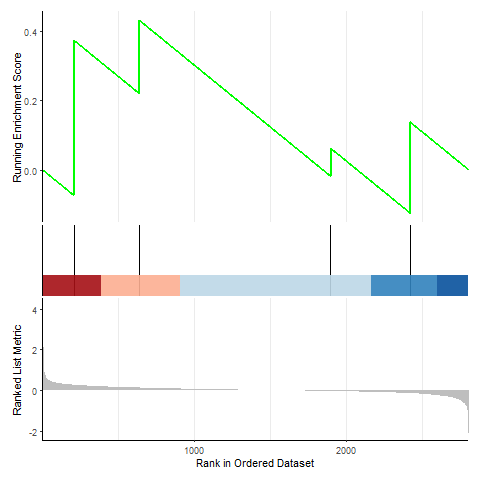

In [52]:
%%R -i resultdir -i CellType
p <- gseaplot2(gsea_reactome_genescore, geneSetID = "R-HSA-8939246",subplots = 1:6,pvalue_table = F)
## Initiate writing to PDF file
pdf(paste0(resultdir,CellType,
       "_GSE_RUNX1_pct_",min_pct_threshold,
        "_logfc.thres_",logfc.threshold,
        "_Ranks_gs.pdf"), height = 8.5, width = 11)
## Create a graphical object g here
print(p)# print it
## Stop writing to the PDF file
dev.off()
p

# KEGG GSEA ONLY POSSITIVE & ONLY NEG

In [53]:
%%R
library(enrichplot)
# Calculate RANKS based on genescore
ranks_genescore_pos<- tibble::deframe( DE_Seurat_mapped %>% filter(gene.score>0) %>%  dplyr::select(entrezID , gene.score )) 
ranks_genescore_pos[1:4]
gsea_kegg_genescore_pos <- gseKEGG(sort(ranks_genescore_pos,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
# ==== Keep only pos enriched
gsea_kegg_genescore_pos  <- gsea_kegg_genescore_pos %>% filter(enrichmentScore>=0)  
readr::write_csv(as.data.frame(gsea_kegg_genescore_pos),
        file=paste0(resultdir,CellType,"_GSEA_KEGG_MinPct_",min_pct_threshold,"_Ranks_genescore_POS.csv"))

# Calculate RANKS based on genescore
ranks_genescore_neg<- tibble::deframe( DE_Seurat_mapped %>% filter(gene.score<0) %>%  dplyr::select(entrezID , gene.score )) 
ranks_genescore_neg[1:4]
gsea_kegg_genescore_neg <- gseKEGG(sort(ranks_genescore_neg,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
# ==== Keep only pos enriched
gsea_kegg_genescore_neg  <- gsea_kegg_genescore_neg %>% filter(enrichmentScore<=0)  
readr::write_csv(as.data.frame(gsea_kegg_genescore_neg),
        file=paste0(resultdir,CellType,"_GSEA_KEGG_MinPct_",min_pct_threshold,"_Ranks_genescore_NEG.csv"))

In [54]:
%%R
# ====================================== PLOTTING  POS =====================================================================
temp_dir <- paste0(resultdir,"Top10_Upreg_GSEA_Kegg_GSEAPlot_ONLY_POS/")
dir.create(temp_dir)
for (row_iter in c(1:10)){
    id_term <- gsea_kegg_genescore_pos$ID[row_iter]
    text_term <- gsea_kegg_genescore_pos$Description[row_iter]
    p <- gseaplot2(gsea_kegg_genescore_pos, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_GS_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_pos.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [55]:
%%R
# ====================================== PLOTTING  POS =====================================================================
sort_filt_gsea_kegg_genescore <- gsea_kegg_genescore_pos[match(tolower(as.vector(kegg_pos_mat$term)[1:10]),tolower(gsea_kegg_genescore_pos$Description))%>% na.omit(),]
temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_KeggGSEAPlot_ONLY_POS/")
dir.create(temp_dir)
top_pos <- sort_filt_gsea_kegg_genescore
for (row_iter in 1:dim(sort_filt_gsea_kegg_genescore)[1]){
    id_term <- top_pos$ID[row_iter]
    text_term <- top_pos$Description[row_iter]
    p <- gseaplot2(gsea_kegg_genescore_pos, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GS_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_pos.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [56]:
%%R
# ====================================== PLOTTING  POS =====================================================================
temp_dir <- paste0(resultdir,"Top10_Upreg_GSEA_Kegg_GSEAPlot_ONLY_NEG/")
dir.create(temp_dir)
for (row_iter in c(1:10)){
    id_term <- gsea_kegg_genescore_neg$ID[row_iter]
    text_term <- gsea_kegg_genescore_neg$Description[row_iter]
    p <- gseaplot2(gsea_kegg_genescore_neg, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_GS_KEGG_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_genescore_only_neg.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [57]:
%%R
# ====================================== PLOTTING  NEG =====================================================================
sort_filt_gsea_kegg_genescore <- gsea_kegg_genescore_neg[match(tolower(as.vector(kegg_neg_mat$term[1:10])),tolower(gsea_kegg_genescore_neg$Description))%>% na.omit(),]
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_KeggGSEAPlot_ONLY_NEG/")
dir.create(temp_dir)
top_neg <- sort_filt_gsea_kegg_genescore
for (row_iter in 1:dim(sort_filt_gsea_kegg_genescore)[1]){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$Description[row_iter]
    p <- gseaplot2(gsea_kegg_genescore_neg, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_KEGG_GS_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_neg.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

# Reactome GSEA ONLY POSSITIVE & ONLY NEG

In [58]:
%%R
library(ReactomePA)
require(clusterProfiler)
# Calculate RANKS based on genescore
ranks_genescore_pos<- tibble::deframe( DE_Seurat_mapped %>% filter(gene.score>0) %>%  dplyr::select(entrezID , gene.score )) 
ranks_genescore_pos[1:4]
gsea_Reactome_genescore_pos <- gsePathway(sort(ranks_genescore_pos,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
# ==== Keep only pos enriched
gsea_Reactome_genescore_pos  <- gsea_Reactome_genescore_pos %>% filter(enrichmentScore>=0)  
readr::write_csv(as.data.frame(gsea_Reactome_genescore_pos),
        file=paste0(resultdir,CellType,"_GSEA_Reactome_MinPct_",min_pct_threshold,"_Ranks_genescore_POS.csv"))

# Calculate RANKS based on genescore
ranks_genescore_neg<- tibble::deframe( DE_Seurat_mapped %>% filter(gene.score<0) %>%  dplyr::select(entrezID , gene.score )) 
ranks_genescore_neg[1:4]
gsea_Reactome_genescore_neg <- gsePathway(sort(ranks_genescore_neg,decreasing=T), nPerm=10000,
                pvalueCutoff=1,minGSSize = 0,
                pAdjustMethod="BH", verbose=FALSE)
# ==== Keep only neg enriched
gsea_Reactome_genescore_neg  <- gsea_Reactome_genescore_neg %>% filter(enrichmentScore<=0)  
readr::write_csv(as.data.frame(gsea_Reactome_genescore_neg),
        file=paste0(resultdir,CellType,"_GSEA_Reactome_MinPct_",min_pct_threshold,"_Ranks_genescore_NEG.csv"))

In [59]:
%%R
head(gsea_Reactome_genescore_pos)

                         ID
R-HSA-2559586 R-HSA-2559586
R-HSA-2559584 R-HSA-2559584
R-HSA-2559583 R-HSA-2559583
R-HSA-140342   R-HSA-140342
R-HSA-5357801 R-HSA-5357801
R-HSA-5210891 R-HSA-5210891
                                                                 Description
R-HSA-2559586                  DNA Damage/Telomere Stress Induced Senescence
R-HSA-2559584 Formation of Senescence-Associated Heterochromatin Foci (SAHF)
R-HSA-2559583                                            Cellular Senescence
R-HSA-140342                             Apoptosis induced DNA fragmentation
R-HSA-5357801                                          Programmed Cell Death
R-HSA-5210891                          Uptake and function of anthrax toxins
              setSize enrichmentScore      NES       pvalue  p.adjust    qvalue
R-HSA-2559586      12       0.8838547 1.902412 0.0001027116 0.1677280 0.1677280
R-HSA-2559584       7       0.9516169 1.876118 0.0003276182 0.1783335 0.1783335
R-HSA-2559583      30    

In [60]:
%%R
head(gsea_Reactome_genescore_neg)

                         ID                                       Description
R-HSA-210990   R-HSA-210990                               PECAM1 interactions
R-HSA-389359   R-HSA-389359                       CD28 dependent Vav1 pathway
R-HSA-1433559 R-HSA-1433559                       Regulation of KIT signaling
R-HSA-8951936 R-HSA-8951936                           RUNX3 regulates p14-ARF
R-HSA-2219530 R-HSA-2219530 Constitutive Signaling by Aberrant PI3K in Cancer
R-HSA-2586552 R-HSA-2586552                               Signaling by Leptin
              setSize enrichmentScore       NES     pvalue  p.adjust    qvalue
R-HSA-210990        5      -0.8653768 -1.534155 0.01244716 0.9740804 0.9740804
R-HSA-389359        4      -0.8952302 -1.519209 0.01231527 0.9740804 0.9740804
R-HSA-1433559       5      -0.8460525 -1.499897 0.02148896 0.9740804 0.9740804
R-HSA-8951936       4      -0.8700491 -1.476476 0.02352217 0.9740804 0.9740804
R-HSA-2219530       9      -0.7450618 -1.462663 0.02736529 

In [61]:
%%R
as.vector(reactome_pos_mat$term)[1:10]

 [1] "Signaling By ERBB2 ECD Mutants"                         
 [2] "Signaling By ALK Fusions And Activated Point Mutants"   
 [3] "Signaling By ERBB2 KD Mutants"                          
 [4] "Signaling By ERBB2 In Cancer"                           
 [5] "TCR Signaling"                                          
 [6] "Interferon Signaling"                                   
 [7] "DDX58/IFIH1-mediated Induction Of Interferon-Alpha/Beta"
 [8] "Constitutive Signaling By Overexpressed ERBB2"          
 [9] "Adaptive Immune System"                                 
[10] "Interferon Gamma Signaling"                             


In [62]:
%%R
tolower(gsea_Reactome_genescore_pos$Description)[1:10]

 [1] "dna damage/telomere stress induced senescence"                 
 [2] "formation of senescence-associated heterochromatin foci (sahf)"
 [3] "cellular senescence"                                           
 [4] "apoptosis induced dna fragmentation"                           
 [5] "programmed cell death"                                         
 [6] "uptake and function of anthrax toxins"                         
 [7] "apoptosis"                                                     
 [8] "apoptotic execution phase"                                     
 [9] "cellular responses to stimuli"                                 
[10] "cellular responses to stress"                                  


In [63]:
%%R
gsea_Reactome_genescore_pos$Description[1:10]

 [1] "DNA Damage/Telomere Stress Induced Senescence"                 
 [2] "Formation of Senescence-Associated Heterochromatin Foci (SAHF)"
 [3] "Cellular Senescence"                                           
 [4] "Apoptosis induced DNA fragmentation"                           
 [5] "Programmed Cell Death"                                         
 [6] "Uptake and function of anthrax toxins"                         
 [7] "Apoptosis"                                                     
 [8] "Apoptotic execution phase"                                     
 [9] "Cellular responses to stimuli"                                 
[10] "Cellular responses to stress"                                  


In [64]:
%%R
# ====================================== PLOTTING  POS =====================================================================
temp_dir <- paste0(resultdir,"Top10_Upreg_GSEA_Reactome_GSEAPlot_ONLY_POS/")
dir.create(temp_dir)
for (row_iter in c(1:10)){
    id_term <- gsea_Reactome_genescore_pos$ID[row_iter]
    text_term <- gsea_Reactome_genescore_pos$Description[row_iter]
    p <- gseaplot2(gsea_Reactome_genescore_pos, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_GS_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_pos.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [65]:
%%R
# ====================================== PLOTTING  POS =====================================================================
sort_filt_gsea_Reactome_genescore <- gsea_Reactome_genescore_pos[match(tolower(as.vector(reactome_pos_mat$term))[1:10],tolower(gsea_Reactome_genescore_pos$Description))%>% na.omit(),]
temp_dir <- paste0(resultdir,"Top10_Upreg_Enriched_Reactome_GSEAPlot_ONLY_POS/")
dir.create(temp_dir)
print(dim(sort_filt_gsea_Reactome_genescore))
top_pos <- sort_filt_gsea_Reactome_genescore
for (row_iter in 1:dim(sort_filt_gsea_Reactome_genescore)[1]){
    id_term <- top_pos$ID[row_iter]
    text_term <- top_pos$Description[row_iter]
    p <- gseaplot2(gsea_Reactome_genescore_pos, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_pos.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1] 10 11


In [66]:
%%R
# ====================================== PLOTTING  neg =====================================================================
temp_dir <- paste0(resultdir,"Top10_Downreg_GSEA_Reactome_GSEAPlot_ONLY_NEG/")
dir.create(temp_dir)

for (row_iter in c(1:10)){
    id_term <- gsea_Reactome_genescore_neg$ID[row_iter]
    text_term <- gsea_Reactome_genescore_neg$Description[row_iter]
    p <- gseaplot2(gsea_Reactome_genescore_neg, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_GS_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_neg.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

In [67]:
%%R
# ====================================== PLOTTING  NEG =====================================================================
sort_filt_gsea_Reactome_genescore <- gsea_Reactome_genescore_neg[match(tolower(as.vector(reactome_neg_mat$term)[1:10]),tolower(gsea_Reactome_genescore_neg$Description))%>% na.omit(),]
temp_dir <- paste0(resultdir,"Top10_Downreg_Enriched_Reactome_GSEAPlot_ONLY_NEG/")
dir.create(temp_dir)
print(dim(sort_filt_gsea_Reactome_genescore))

top_neg <- sort_filt_gsea_Reactome_genescore
for (row_iter in 1:dim(sort_filt_gsea_Reactome_genescore)[1]){
    id_term <- top_neg$ID[row_iter]
    text_term <- top_neg$Description[row_iter]
    p <- gseaplot2(gsea_Reactome_genescore_neg, geneSetID = id_term,subplots = 1:3,pvalue_table = F,title=text_term)
    ## Initiate writing to PDF file
    pdf(paste0(temp_dir,CellType,
        "_Enr_React_GSPlot_",id_term,"_pct_",min_pct_threshold,
            "_logfc.thres_",logfc.threshold,
            "_Ranks_gs_only_neg.pdf"), height = 8.5, width = 11)
    ## Create a graphical object g here
    print(p)# print it
    ## Stop writing to the PDF file
    dev.off()
}

[1]  9 11


# END

In [68]:
%%R
sessionInfo()

R version 4.2.2 (2022-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22621)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ReactomePA_1.42.0           enrichplot_1.18.4          
 [3] EnhancedVolcano_1.16.0      ggrepel_0.9.2              
 [5] clusterProfiler_4.6.2       org.Hs.eg.db_3.16.0        
 [7] AnnotationDbi_1.60.2        forcats_1.0.0              
 [9] purrr_1.0.1                 readr_2.1.3                
[11] tidyr_1.3.0                 tibble_3.2.0               
[13] tidyverse_1.3.2             enrichR_3.2                
[15] DESeq2_1.38.3               dittoSeq_1.10.0      